c:\Users\nzup_\anaconda3\envs\langchainstudy\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


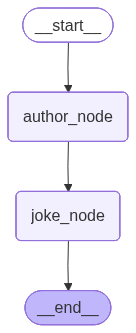

In [1]:
import os
from typing import TypedDict

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START, END
from langgraph.graph import StateGraph
from pydantic import SecretStr
from typing_extensions import NotRequired

load_dotenv()

llm = ChatOpenAI(
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    model="qwen-plus",
    api_key=SecretStr(os.environ["API_KEY"]),
)

class State(TypedDict):
    author:NotRequired[str]
    joke:NotRequired[str]

def author_node(state:State):
    prompt='帮我推荐一位受人们欢迎的作家。只需要给出作家的名字即可。'
    author=llm.invoke(prompt)
    return {'author':author.content}

def joke_node(state:State):
    prompt=f"用作家{state['author']}的风格，写一个100字以内的笑话"
    joke=llm.invoke(prompt)
    return {'joke':joke.content}

builder = StateGraph(State)
builder.add_node(author_node)
builder.add_node(joke_node)

builder.add_edge(START, "author_node")
builder.add_edge("author_node", "joke_node")
builder.add_edge("joke_node", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)
graph



In [2]:
import uuid
config={
    "configurable":{
        "thread_id":uuid.uuid4(),
    }
}
state=graph.invoke({},config)
state

{'author': '村上春树',
 'joke': '深夜的冰箱里，最后一片芝士突然开口：“喂，三明治，你为什么总盯着我看？”  \n三明治沉默片刻，说：“我在想，没有你的话，我算什么。”  \n芝士叹了口气：“哲学问题，留到明天再想吧，现在——我们先逃出这该死的保鲜盒。”  \n可他们忘了，猫已经在门外蹲了一整晚。'}

In [5]:
# 查看所有checkpoint检查点
states = list(graph.get_state_history(config))

# 推荐作家那一步
selected_state = states[1]

# 重新设定State
new_config = graph.update_state(selected_state.config, values={"author": "郭德纲"})

# 重新执行Graph
graph.invoke(None, new_config)


{'author': '郭德纲',
 'joke': '话说一小伙子去算命，先生掐指一算：“你命里缺德！”  \n小伙子乐了：“嗨，我们家祖传缺德——我爹叫郭全德，我爷叫郭盛德，到我这儿，干脆叫郭德纲！”  \n先生一听，赶紧收摊：“得嘞，这德您自个儿留着吧，我怕挨骂！”  \n\n（98字）'}

In [10]:
import os
import datetime
from deepagents import create_deep_agent
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from pydantic import SecretStr
load_dotenv()

llm = ChatOpenAI(
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    model="qwen-plus",
    api_key=SecretStr(os.environ["API_KEY"]),
)

def get_date():
    """获取当前日期"""
    print("调用了get_date函数")
    return datetime.datetime.now().strftime("%Y-%m-%d")

def get_weather(city: str, date: str):
    """获取城市的天气"""
    print("调用了get_weather函数")
    return f"城市{city}在{date}的天气是：晴天"

deep_agent = create_deep_agent(
    llm,
    tools=[get_date, get_weather],
    system_prompt="""
你是一个助手，现在有以下一些工具可以使用：
## `get_date`: 获取当前日期
## `get_weather`: 获取城市的天气
结合这些工具，完成用户的请求。
"""
)
response = deep_agent.invoke({"messages":[{"role":"user","content":"明天星期几？这一天长沙的天气怎么样？"}]})

for message in response["messages"]:
    print(message)
    print("================")
print(response["messages"][-1].content)


调用了get_date函数
调用了get_weather函数
content='明天星期几？这一天长沙的天气怎么样？' additional_kwargs={} response_metadata={} id='36249782-a53f-4731-9fbf-f2ab684ad922'
content='' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 5104, 'total_tokens': 5119, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'qwen-plus', 'system_fingerprint': None, 'id': 'chatcmpl-888553ea-84a7-4e98-a8d6-fde93f562f06', 'finish_reason': 'tool_calls', 'logprobs': None} id='lc_run--f5a13bf6-fa27-402f-8efe-c890742ca25c-0' tool_calls=[{'name': 'get_date', 'args': {}, 'id': 'call_00d58e9838db4ec4942808', 'type': 'tool_call'}] usage_metadata={'input_tokens': 5104, 'output_tokens': 15, 'total_tokens': 5119, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}}
content='2025-12-02' name='get_date' id='53b749b3-a523-44f9-a9ff-7d3654ac3ee1' tool_call_id='call_00d58e9

In [9]:
import datetime
import os

from deepagents.backends import FilesystemBackend

from deepagents import create_deep_agent
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from pydantic import SecretStr

load_dotenv()

llm = ChatOpenAI(
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    model="qwen-plus",
    api_key=SecretStr(os.environ["API_KEY"]),
)
deep_agent = create_deep_agent(
    llm,
    backend=FilesystemBackend(root_dir="D:/langchainstudy")
)

response = deep_agent.invoke({
    "messages": [
        {
            "role": "user",
            "content": "列出langchainstudy目录下所有文件的名称。"
        }
    ]
})

for message in response["messages"]:
    print(message)
    print("================")


content='列出langchainstudy目录下所有文件的名称。' additional_kwargs={} response_metadata={} id='b368c15b-32f2-422a-a2b8-6665e76bf90b'
content='' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 4963, 'total_tokens': 4983, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'qwen-plus', 'system_fingerprint': None, 'id': 'chatcmpl-584a086d-7cb7-43f5-85b9-3340d3a6ff09', 'finish_reason': 'tool_calls', 'logprobs': None} id='lc_run--ddd6c20f-676a-4dfb-ab02-4ff759daea52-0' tool_calls=[{'name': 'ls', 'args': {'path': '/langchainstudy'}, 'id': 'call_42b2b98f6c06432ab062bb', 'type': 'tool_call'}] usage_metadata={'input_tokens': 4963, 'output_tokens': 20, 'total_tokens': 4983, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}}
content="['D:\\\\langchainstudy\\\\.env', 'D:\\\\langchainstudy\\\\.idea/', 'D:\\\\langchainstudy\\\\accessK